# CNN for Steering - Experiment 1 #

In this experiment we explored the performance of the **NVIDIA proposed End to End CNN model** for learning steering. 

Created on Sun Mar  7 20:08:24 2021

@author: 
Kevin Machado Gamboa
Group Project Team 6

Last modified:


## References:
    
1. **End to End Learning for Self-Driving Cars**, Karol Zieba, NVIDIA Corporation [link](https://arxiv.org/pdf/1604.07316v1.pdf)
    
2. **How to Simulate a Self-Driving Car**, Siraj Raval [GitHib link](https://github.com/llSourcell/How_to_simulate_a_self_driving_car/blob/master/model.py)

##  Libraries

In [1]:
import os
import cv2 as cv
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image
from pathlib import Path
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

Configuring Tensorflow GPU

In [2]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')

if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)
    
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten

1 Physical GPUs, 1 Logical GPUs


Developed Functions

In [3]:
def plot_steering(x):
    
    fig, ax = plt.subplots(figsize=(15,3))
    # adding circunference
    ax.plot(np.linspace(-1,1,50), np.sqrt(1 - np.linspace(-1,1,50)**2))
    # adding steering value
    ax.scatter(x, np.sqrt(1-x**2), c='r', s= 300, marker="o", alpha=0.5)
    
    ax.axvline(ls='--',c='grey', lw=1)
    
    ax.set(title= 'Steering Output Visualization', xlabel= 'normaliza values')
    ax.annotate('Right', xy=(0.2, 0.4), fontsize=50)
    ax.annotate('Left', xy=(-0.5, 0.4), fontsize=50)
    
    fig.show()

def transform_im(im, newsize):
    small_img = cv.resize(im, newsize)
    small_img = np.array(small_img)
    small_img = small_img[None, :, :, :]
    return(small_img)

def normalize(x, mi, ma):
    return (x-mi)/(ma-mi)

def re_scale(x, mi, ma):
    return x * (ma-mi) + mi

## 1.Data Loading

In [4]:
# Loading Labels
data_ann_path = '../../../data'
data_out = pd.read_csv(data_ann_path + '/_controls.csv')
y = data_out.steer

# Loading Images
im_path = os.path.abspath('..\..\..\data\lane_detection')
im_files = os.listdir(im_path)
newsize = (300, 300)
im_dataset_pil = []
X = []
for idx, name in tqdm(enumerate(im_files)):
    X.append(cv.resize(cv.imread(os.path.join(im_path, name)), newsize, interpolation = cv.INTER_AREA)/127.5-1.0)
#   im_dataset_pil.append(Image.open(os.path.join(im_path, name)))
#   X.append(np.array(im_dataset_pil[idx].resize(newsize))/127.5-1.0)

255it [00:23, 11.07it/s]


### Steering Visualizarion

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


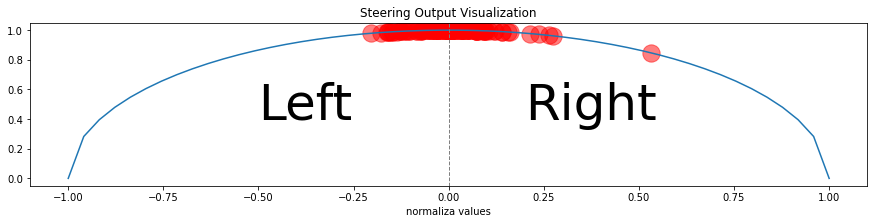

In [5]:
plot_steering(y)

In [6]:
X = np.array(X)
mi, ma = min(y), max(y)
y = normalize(np.array(y),mi,ma)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=0)

In [7]:
input_shape = X_train[0].shape
print('Input shape:', input_shape)

Input shape: (300, 300, 3)


## 2. Model Development

In [8]:
def model_steering():
  model = tf.keras.Sequential([
    Conv2D(24, 5, 5, activation='elu', padding='same', input_shape=input_shape),
    Conv2D(36, 5, 5, activation='elu', padding='same'),
    Conv2D(48, 5, 5, activation='elu', padding='same'),
    Conv2D(64, 3, 3, activation='elu', padding='same'),
    Conv2D(64, 3, 3, activation='elu', padding='same'),
    Dropout(0.5),
    Flatten(),
    Dense(100, activation='elu'),
    Dense(50, activation='elu'),
    Dense(10, activation='elu'),
    Dense(1)
  ])
  # Model Parameters
  optimus = tf.keras.optimizers.Adam(lr=1.0e-5)
  model.compile(optimizer=optimus,
                loss='mse')
  return model

model = model_steering()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 60, 60, 24)        1824      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 12, 12, 36)        21636     
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 3, 3, 48)          43248     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 1, 1, 64)          27712     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 1, 1, 64)          36928     
_________________________________________________________________
dropout (Dropout)            (None, 1, 1, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0

In [9]:
checkpoint_path = 'saved_model/'
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path+'model-{epoch:03d}.h5',
                                 monitor='val_loss',
                                 verbose=0,
                                 save_best_only=True,
                                 mode='auto')
X_train, X_val, y_train, y_val
history_1 = model.fit(X_train, y_train, epochs=600, batch_size=50, validation_data=(X_val, y_val), callbacks = [early_stop, checkpoint])

Epoch 1/600
5/5 [==============================] - 11s 642ms/step - loss: 0.0888 - val_loss: 0.0962
Epoch 2/600
5/5 [==============================] - 1s 116ms/step - loss: 0.0847 - val_loss: 0.0869
Epoch 3/600
5/5 [==============================] - 1s 113ms/step - loss: 0.0744 - val_loss: 0.0785
Epoch 4/600
5/5 [==============================] - 1s 117ms/step - loss: 0.0668 - val_loss: 0.0709
Epoch 5/600
5/5 [==============================] - 1s 112ms/step - loss: 0.0657 - val_loss: 0.0639
Epoch 6/600
5/5 [==============================] - 1s 119ms/step - loss: 0.0576 - val_loss: 0.0579
Epoch 7/600
5/5 [==============================] - 1s 124ms/step - loss: 0.0634 - val_loss: 0.0526
Epoch 8/600
5/5 [==============================] - 1s 113ms/step - loss: 0.0513 - val_loss: 0.0480
Epoch 9/600
5/5 [==============================] - 1s 161ms/step - loss: 0.0467 - val_loss: 0.0437
Epoch 10/600
5/5 [==============================] - 1s 113ms/step - loss: 0.0432 - val_loss: 0.0400
Epoch 11

C:\Users\kevin\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  from ipykernel import kernelapp as app


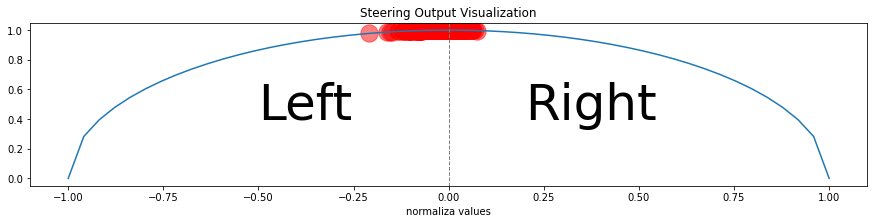

In [11]:
plot_steering(re_scale(model.predict(X), mi, ma))

In [12]:
model.save('Nvidia_based_model.h5')